

# Object detection with Intel® Distribution of OpenVINO™ toolkit

This tutorial uses a Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model to walk you through the basic steps of using two key components of the Intel® Distribution of OpenVINO™ toolkit: Model Optimizer and Inference Engine.

Model Optimizer is a cross-platform command-line tool that takes pre-trained deep learning models and optimizes them for performance/space using conservative topology transformations. It performs static model analysis and adjusts deep learning models for optimal execution on end-point target devices.

Inference is the process of using a trained neural network to interpret data, such as images. This lab feeds a short video of cars, frame-by-frame, to the Inference Engine which subsequently utilizes an optimized trained neural network to detect cars.





    
## Part 1: Optimize a deep-learning model using the Model Optimizer (MO)

In this section, you will use the Model Optimizer to convert a trained model to two Intermediate Representation (IR) files (one .bin and one .xml). The Inference Engine requires this model conversion so that it can use the IR as input and achieve optimum performance on Intel hardware.


### 1. Importing Dependencies

In [1]:
from IPython.display import HTML
import os
import time
import sys                                     
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent.parent))
from demoTools.demoutils import *

Now, using the model downloader tool we will download the required models that are helpful in this exercise. We will use the **MobileNet-SSD** model. Download the model, specifying the name and output directory.

In [2]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o models

################|| Downloading models ||################

========== Downloading models/public/mobilenet-ssd/mobilenet-ssd.prototxt
... 100%, 28 KB, 44922 KB/s, 0 seconds passed

========== Downloading models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 22257 KB/s, 1 seconds passed

################|| Post-processing ||################




    
### 2. Run the Model Optimizer on the pretrained Caffe* model. This step generates one .xml file and one .bin file and place both files in the tutorial samples directory (located here: models//object-detection/)

In [3]:
! python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_caffe.py --input_model models/public/mobilenet-ssd/mobilenet-ssd.caffemodel -o models/mobilenet-ssd/FP32 --scale 256 --mean_values [127,127,127]

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u30239/Smart_video_review/iot-devcloud/smart-video-workshop/object-detection/devcloud/cpp/models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u30239/Smart_video_review/iot-devcloud/smart-video-workshop/object-detection/devcloud/cpp/models/mobilenet-ssd/FP32
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Path to Python Caffe* parser generated from caffe.



   Note: Although this tutorial uses Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model, the Inference Engine is compatible with other neural network architectures, such as AlexNet*, GoogleNet*, MxNet* etc.


The Model Optimizer converts a pretrained Caffe* model to make it compatible with the Intel Inference Engine and optimizes it for Intel® architecture. These are the files you would include with your C++ application to apply inference to visual data.

   Note: if you continue to train or make changes to the Caffe* model, you would then need to re-run the Model Optimizer on the updated model.

### 3. Navigate to the tutorial sample model directory and verify creation of the optimized model files (the IR files)

In [5]:
!ls models/mobilenet-ssd/FP32/

mobilenet-ssd.bin  mobilenet-ssd.mapping  mobilenet-ssd.xml



    
You should see the following two files listed in this directory: mobilenet-ssd.xml and mobilenet-ssd.bin


## Part 2: Use the mobilenet-ssd* model and Inference Engine in an object detection application


### 1. Open the sample app [main.cpp](main.cpp)  and view the lines that call the Inference Engine.


- Line 135 — loads the Inference Engine plugin for use within the application
- Line 148 — initializes the network object
- Line 215 — loads model to the plugin
- Line 233 — allocate input blobs
- Line 242 — allocate output blobs
- Line 315 — runs inference using the optimized model

The code in this demo is separated into two parts. First part is responsible for reading the input stream and running the object detection inference workload on the stream. This part outputs Region Of Interest (ROI), in terms of coordinates, for each frame. The source code for this part can be found in [main.cpp](main.cpp) , and the executable will be named "tutorial1". Output ROI will be written into a text file, "ROIs.txt".

The second part reads the ROIs.txt file, and overlays boxes on each frame of the stream based on the coordinates. Then the output video is written into a file. The source code for this step is in [ROI_writer.cpp](ROI_writer.cpp).

We have provided a Makefile for compiling the examples. Run the following cell to compile the application. (tip: use crtl+enter to run the cell)

In [52]:
!make

g++ -fPIE -O3 -fopenmp -o tutorial1 --std=c++11 main.cpp -I/opt/intel/openvino_2019.3.334/deployment_tools/inference_engine/include -I/opt/intel/openvino_2019.3.334/deployment_tools/inference_engine/include/cpp/ -I/opt/intel/openvino_2019.3.334/deployment_tools/inference_engine/samples/common/ -I/opt/intel/openvino_2019.3.334/deployment_tools/inference_engine/src/extension/ -I/opt/intel/openvino_2019.3.334/opencv/include -L/opt/intel/openvino_2019.3.334/deployment_tools/inference_engine/lib/intel64 -L/opt/intel/openvino_2019.3.334/opencv/lib -L/opt/intel/openvino/deployment_tools/inference_engine/samples/build/intel64/Release/lib/ -lgflags -linference_engine -ldl -lpthread -lcpu_extension_avx2 -lopencv_core -lopencv_imgcodecs -lopencv_imgproc -lopencv_highgui -lopencv_videoio -lopencv_video -lgflags  
main.cpp: In function ‘int main(int, char**)’:
main.cpp:175:43: warning: ‘InferenceEngine::SizeVector InferenceEngine::InputInfo::getDims() const’ is deprecated [-Wdeprecated-declarations

The two executables, tutorial1 and ROIwriter, take a number of commandline arguments.

Run the following cells to see the list of the available arguments:

In [53]:
!./tutorial1 -h


[usage]
	tutorial1 [option]
	options:

		-h              Print a usage message
		-i <path>       Required. Path to input video file
		-model <path>   Required. Path to model file.
		-b #            Batch size.
		-thresh #       Threshold (0-1: .5=50%)
		-d <device>     Infer target device (CPU or GPU or MYRIAD)
		-fr #           maximum frames to process
		-o #            Path to the output ROIs file


In [54]:
!./ROI_writer -h


[usage]
	ROIviewer [option]
	options:

		-h              Print a usage message
		-i <path>       Required. Path to input video file
		-ROIfile <path> Path to ROI file.
		-b #            Batch # to display.
		-l <path>       class labels file.
		-o <filename>       Output file path.
		-r <res>       (double) factor to cut reolution by; 2. will cut the resolution by half.
		-k <keepframe>       Writer will keep every <skipframe> frames.


### 3. Source your environmental variables

In [55]:
! /opt/intel/openvino/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


We will be using the below cars video in this example to detect the cars from the input video.  

In [29]:
videoHTML('Sample Video', 
          ['cars_1900.mp4'])


    
### 4. Run the sample application to use the Inference Engine on the test video

#### Create Job Script 

We will run the workload on several DevCloud's edge compute nodes. We will send work to the edge compute nodes by submitting jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

To pass the specific variables to the Python code, we will use following arguments:

* `-f`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;location of the optimized models XML
* `-i`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;location of the input video
* `-r`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;output directory
* `-d`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hardware device type (CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
* `-n`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;number of infer requests

The job file will be executed directly on the edge compute node.

In [56]:
%%writefile object_detection_job.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR
OUTPUT_FILE=$1
DEVICE=$2
FP_MODEL=$3
# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
#  The output directory is the first argument of the bash script
mkdir -p $OUTPUT_FILE
ROIFILE=$OUTPUT_FILE/ROIs.txt
OVIDEO=$OUTPUT_FILE/output.mp4

# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
./tutorial1 -i cars_1900.mp4 \
            -m models/mobilenet-ssd/$FP_MODEL/mobilenet-ssd.xml \
            -d $DEVICE \
            -o $OUTPUT_FILE\
            -fr 3000 

# Converting the text output to a video
./ROI_writer -i cars_1900.mp4 \
             -o $OUTPUT_FILE \
             -ROIfile $ROIFILE \
             -l pascal_voc_classes.txt \
             -r 2.0 # output in half res

Overwriting object_detection_job.sh


#### Submitting to a node with Intel® Core™ CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel 
    Core i5-6500TE</a>. The inference workload will run on the CPU.

In [57]:
print("Submitting a job to an edge compute node with an Intel Core CPU...")
#Submit job to the queue
job_id_core = !qsub object_detection_job.sh -l nodes=1:tank-870:i5-6500te -F "results/core CPU FP32" -N obj_det_core
print(job_id_core[0])
#Progress indicators
if job_id_core:
    progressIndicator('results/core', 'i_progress_'+job_id_core[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/core', 'v_progress_'+job_id_core[0]+'.txt', "Rendering", 0, 100)

Submitting a job to an edge compute node with an Intel Core CPU...
4282.v-qsvr-1.devcloud-edge


### 5. Display output


You should see a video play with cars running on the highway and bounding boxes around them.

In [58]:
videoHTML('IEI Tank (Intel Core CPU)',
          ['results/core/output.mp4'],
          'results/core/stats.txt')


    
## Part 3: Run the example on different hardware



    
In the previous exercise we saw the time it took for inference in CPU, Now we will run the same sample on GPU and see the total time it takes to run the inference.

#### Submitting to a node with Intel® Core CPU and using the onboard Intel GPU

In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.
    
    
Set target hardware as GPU with -d GPU

In [59]:
print("Submitting a job to an edge compute node with an Intel Core CPU and an Intel GPU...")
#Submit job to the queue
job_id_gpu = !qsub object_detection_job.sh -l nodes=1:tank-870:i5-6500te -F "results/gpu GPU FP32" -N obj_det_gpu
print(job_id_gpu[0])
#Progress indicators
if job_id_gpu:
    progressIndicator('results/gpu', 'i_progress_'+job_id_gpu[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/gpu', 'v_progress_'+job_id_gpu[0]+'.txt', "Rendering", 0, 100)

Submitting a job to an edge compute node with an Intel Core CPU and an Intel GPU...
4283.v-qsvr-1.devcloud-edge


In [60]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)',
          ['results/gpu/output.mp4'],
          'results/gpu/stats.txt')


    
The total time between CPU and GPU will vary depending on your system.

## Step 4: Assess Performance

The running time of each inference task is recorded in `results/*/stats.txt`, where the subdirectory name corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Lower values mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

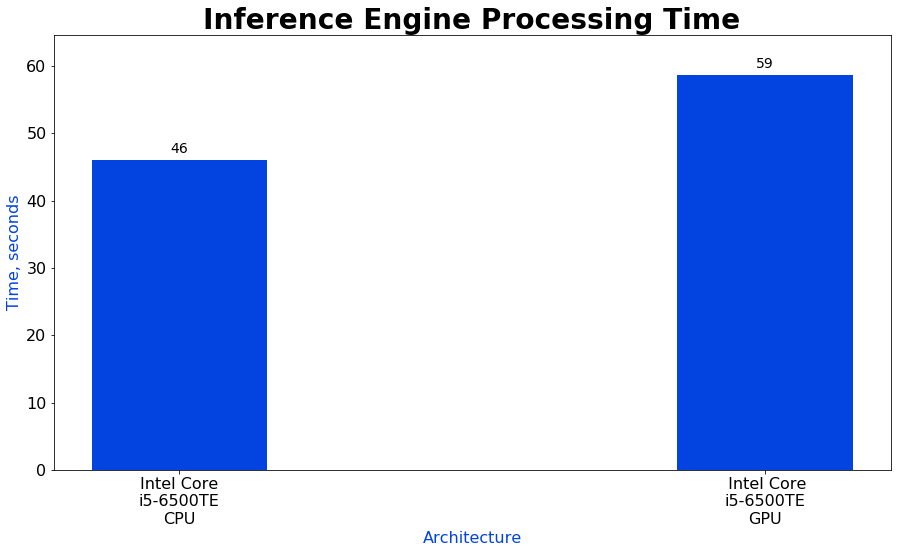

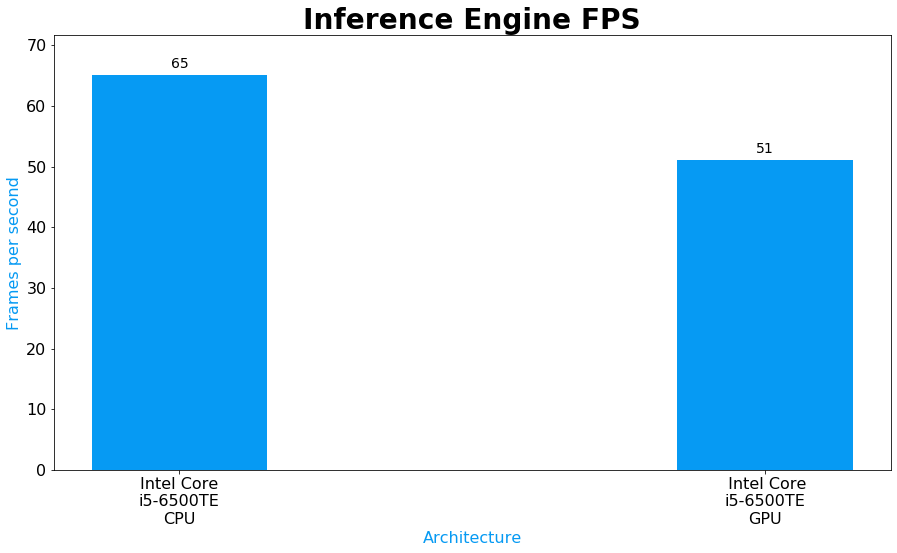

In [61]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU')]
stats_list = []
for arch, a_name in arch_list:
    stats_list.append(('results/{arch}/stats.txt'.format(arch=arch), a_name))
    
summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time', 0.3 )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps', 0.3 )

### Clean the output files before closing the lab
- point to kernel in the header and click on *Restart & Clear Output* to clean the outputs of this page and run the below script to remove results folder.